## 1(A)

In [555]:
import numpy as np
import pandas as pd
import cvxopt
from cvxopt import solvers,matrix
from sklearn.svm import SVC
import math
from tqdm import tqdm
import multiprocessing as mp
from multiprocessing import Pool
import itertools
import threading
import pickle
from joblib import Parallel, delayed
import time
from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sns

In [475]:
def init():
    train = pd.read_csv("fashion_mnist/train.csv",header=None)
    val = pd.read_csv("fashion_mnist/val.csv",header=None)
    test = pd.read_csv("fashion_mnist/test.csv",header=None)
    return train,val,test

In [501]:
train,val,test = init()
c1=4
c2=5

In [502]:
def stripData(data,c1,c2):
    data = data[data[784]==c1].append(data[data[784]==c2])
    data.loc[data[784]==c1,784]=-1
    data.loc[data[784]==c2,784]=1
    Y = np.reshape(np.array(data[784]),(-1,1))
    pos = data[data[784]==1]
    neg = data[data[784]==-1]
    data = np.array(data.drop(columns=[784]))/255
    return data,Y,pos,neg

In [503]:
train = train[train[784]==c1].append(train[train[784]==c2])

In [504]:
train.loc[train[784]==c1,784]=-1
train.loc[train[784]==c2,784]=1
pos = train[train[784]==1]
neg = train[train[784]==-1]
Y = np.array(train[784])
trainD = np.array(train.drop(columns=[784]))/255

In [505]:
Y = Y.reshape((Y.shape[0],1))

In [506]:
trainD.shape

(4500, 784)

In [482]:
def createPq(data,out):
    P = (out@out.T)*(data@data.T)
    q = (-1)*np.ones((P.shape[0],1))
    return matrix(P),matrix(q)

def createGh(m):
    u = np.identity(m)
    d = (-1)*np.identity(m)
    G = np.append(u,d,axis=0)
    h = np.append(np.ones((m,1)),np.zeros((m,1)),axis=0)
    return matrix(G),matrix(h)

def createAb(out):
    m = out.shape[0]
    A = out.copy()
    A = A.T
    b = 0
    return matrix(A,(1,m),'d'),matrix(b,(1,1),'d')

In [483]:
t = time.time()
P,q = createPq(trainD,Y)
G,h = createGh(trainD.shape[0])
A,B = createAb(Y)

In [484]:
sol=solvers.qp(P, q, G, h, A, B)

     pcost       dcost       gap    pres   dres
 0: -1.8144e+02 -7.2340e+03  4e+04  2e+00  2e-12
 1: -1.0203e+02 -3.4492e+03  6e+03  3e-01  1e-12
 2: -3.3534e+01 -9.1974e+02  2e+03  7e-02  8e-13
 3: -1.1925e+01 -4.1859e+02  7e+02  2e-02  4e-13
 4: -3.6847e+00 -1.7770e+02  3e+02  8e-03  2e-13
 5: -1.2594e+00 -5.9907e+01  9e+01  2e-03  6e-14
 6: -6.7211e-01 -2.5705e+01  4e+01  9e-04  3e-14
 7: -4.1327e-01 -1.1925e+01  2e+01  3e-04  2e-14
 8: -5.1263e-01 -5.5495e+00  6e+00  1e-04  2e-14
 9: -5.7700e-01 -3.1645e+00  3e+00  4e-05  2e-14
10: -7.0634e-01 -2.0084e+00  1e+00  3e-06  2e-14
11: -9.3593e-01 -1.4177e+00  5e-01  7e-07  2e-14
12: -1.0291e+00 -1.2146e+00  2e-01  1e-15  2e-14
13: -1.0863e+00 -1.1319e+00  5e-02  1e-15  2e-14
14: -1.1048e+00 -1.1100e+00  5e-03  4e-16  2e-14
15: -1.1073e+00 -1.1074e+00  1e-04  2e-16  2e-14
16: -1.1073e+00 -1.1073e+00  1e-06  2e-15  2e-14
17: -1.1073e+00 -1.1073e+00  1e-08  2e-15  2e-14
Optimal solution found.


In [485]:
alpha = np.array(sol['x'])

In [486]:
alpha.max()

0.2523889277391158

In [487]:
def stripAlpha(alpha,E):
    index = alpha < E
    alpha[index] = 0
    return alpha

In [488]:
alpha = stripAlpha(alpha,1e-4)

In [489]:
alpha.min()

0.0

In [490]:
def calwb(alpha,X,Y,pos,neg):
    w = X.T@(alpha*Y)
    x = (np.array(pos.drop(columns=[784]))/255)
    y = (np.array(neg.drop(columns=[784]))/255)
    b = (-1)*((x@w).min()+(y@w).max())/2
    return w,b

In [491]:
w,b = calwb(alpha,trainD,Y,pos,neg)

In [492]:
print(time.time()-t)

34.946269512176514


In [493]:
def predClasses(w,b,data):
    pred = []
    for i in data:
        temp = i.reshape((1,-1))@w+b
        if temp<0:
            pred.append(-1)
        else:
            pred.append(1)
    return pred

In [494]:
predictionTrain = predClasses(w,b,trainD)

In [495]:
def checkAccuracy(y,pred):
    y = np.array(y).reshape((-1,1))
    pred = np.array(pred).reshape((-1,1))
    check = (y==pred)
    t=0
    f=0
    for i in check:
        if i:
            t=t+1
        else:
            f=f+1
    print(t/(t+f))

In [496]:
checkAccuracy(train[784],predictionTrain)

1.0


In [497]:
testX,testY,_,_ = stripData(test,c1,c2)
valX,valY,_,_ = stripData(val,c1,c2)

In [498]:
predictionTest = predClasses(w,b,testX)
checkAccuracy(testY,np.array(predictionTest))

0.998


In [499]:
testX.shape

(1000, 784)

In [500]:
predictionVal = predClasses(w,b,valX)
checkAccuracy(valY,predictionVal)

0.996


## 1(B)

In [145]:
def K(x,z,gamma=0.05):
#     norm = np.linalg.norm(x-z,ord=2)**2
    norm = np.reshape((x-z),(1,-1))
    norm = norm@norm.T
    return math.exp((-gamma)*norm)

In [146]:
def gaussianPq(data,out):
    m = data.shape[0]
#     kernelMatrix = np.zeros((m,m))
#     for i in tqdm(range(m)):
#         for j in range(m):
#             kernelMatrix[i,j] = K(data[i,:],data[j,:])
    kernelMatrix=np.exp((-0.05)*np.square(distance.cdist(data,data,'euclidean')))
    P = (out@out.T)*kernelMatrix
    q = (-1)*np.ones((P.shape[0],1))
    return matrix(P),matrix(q)

In [147]:
P,q = gaussianPq(trainD,Y)
G,h = createGh(trainD.shape[0])
A,B = createAb(Y)

In [148]:
sol=solvers.qp(P, q, G, h, A, B)

     pcost       dcost       gap    pres   dres
 0: -4.2846e+02 -7.6683e+03  3e+04  2e+00  7e-15
 1: -3.2882e+02 -4.1247e+03  6e+03  2e-01  7e-15
 2: -3.0989e+02 -9.4797e+02  7e+02  2e-02  7e-15
 3: -3.7592e+02 -5.6057e+02  2e+02  4e-03  6e-15
 4: -4.0510e+02 -4.5864e+02  6e+01  7e-04  6e-15
 5: -4.1586e+02 -4.3199e+02  2e+01  1e-04  7e-15
 6: -4.1976e+02 -4.2383e+02  4e+00  1e-05  7e-15
 7: -4.2092e+02 -4.2164e+02  7e-01  6e-14  7e-15
 8: -4.2117e+02 -4.2123e+02  6e-02  2e-13  7e-15
 9: -4.2119e+02 -4.2119e+02  1e-03  5e-13  7e-15
10: -4.2119e+02 -4.2119e+02  2e-05  5e-13  7e-15
Optimal solution found.


In [149]:
alpha = np.array(sol['x'])

In [150]:
# 1e-2 = 98.997 96.3 96.2
# 1e-3 = 99.1 96.1 96
alpha = stripAlpha(alpha,1e-4)

In [151]:
print(alpha.max(),alpha.min())

0.9999999992272367 0.0


In [152]:
def calb(alpha,X,Y,pos,neg):
    x = (np.array(pos.drop(columns=[784]))/255)
    y = (np.array(neg.drop(columns=[784]))/255)
    Y.reshape((-1,1))
    p = ((alpha*Y)*(np.exp((-0.05)*np.square(distance.cdist(X,x,'euclidean'))))).sum(axis=0).min()
    n = ((alpha*Y)*(np.exp((-0.05)*np.square(distance.cdist(X,y,'euclidean'))))).sum(axis=0).max()
    b = (-1)*(p+n)/2
    return b

In [153]:
b = calb(alpha,trainD,Y,pos,neg)

In [154]:
b

-0.14470232827838264

In [171]:
def predGaussianClasses(alpha,b,X,Y,data,return_score=False):
    pred=[]
    pred = ((alpha*Y)*(np.exp((-0.05)*np.square(distance.cdist(X,data,'euclidean'))))).sum(axis=0)
    pred = pred+b
    if(return_score):
        return pred
    index = pred < 0
    pred[index]=-1
    index = pred >= 0
    pred[index]=1
    return pred

In [156]:
predictionTrain = predGaussianClasses(alpha,b,trainD,Y,trainD)
predictionTest = predGaussianClasses(alpha,b,trainD,Y,testX)
predictionVal = predGaussianClasses(alpha,b,trainD,Y,valX)

In [157]:
checkAccuracy(Y,predictionTrain)
checkAccuracy(testY,predictionTest)
checkAccuracy(valY,predictionVal)

0.99
0.961
0.96


## 1(C)

In [40]:
clfLinear = SVC(C=1.0,kernel='linear')
clfGaussian = SVC(C=1.0,kernel='rbf',gamma=0.05)

In [41]:
clfLinear.fit(trainD, train[784])
clfGaussian.fit(trainD, train[784])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [42]:
testX,testY,_,_ = stripData(test,c1,c2)
valX,valY,_,_ = stripData(val,c1,c2)

In [43]:
predictionTrain = clfLinear.predict(trainD)
predictionTest = clfLinear.predict(testX)
predictionVal = clfLinear.predict(valX)

In [44]:
checkAccuracy(train[784],predictionTrain)
checkAccuracy(valY,predictionVal)
checkAccuracy(testY,predictionTest)

0.9862222222222222
0.934
0.943


In [45]:
predictionTrain = clfGaussian.predict(trainD)
predictionTest = clfGaussian.predict(testX)
predictionVal = clfGaussian.predict(valX)

In [46]:
checkAccuracy(train[784],predictionTrain)
checkAccuracy(valY,predictionVal)
checkAccuracy(testY,predictionTest)

0.9902222222222222
0.964
0.965


## 2(A)

In [209]:
globalTrain,globalVal,globalTest = init()

In [210]:
def createClf(data,classes):
    c1 = classes[0]
    c2 = classes[1]
    filteredX,filteredY,pos,neg = stripData(data,c1,c2)

    P,q = gaussianPq(filteredX,filteredY)
    G,h = createGh(filteredX.shape[0])
    A,b = createAb(filteredY)
    sol=solvers.qp(P, q, G, h, A, B)
    alpha = np.array(sol['x'])
    alpha = stripAlpha(alpha,1e-4)
    print("Alpha Done.")
    b = calb(alpha,filteredX,filteredY,pos,neg)
    print("b Done.")
    return (alpha,b,c1,c2)

In [211]:
l = list(itertools.combinations([0,1,2,3,4,5,6,7,8,9], 2))

In [381]:
pickle_in = open("oneVone.pickle","rb")
paraList = pickle.load(pickle_in)

In [212]:
# st = time.time()
# temp = Parallel(n_jobs=-2)(delayed(createClf)(globalTrain,i) for i in l)
# print(time.time()-st)

1709.348060131073


In [344]:
# with open('oneVone.pickle', 'wb') as f:
#     pickle.dump(temp, f)

In [215]:
def classify(paraList,X,data):
    pred=[]
    for i in tqdm(paraList):
        filteredX,filteredY,pos,neg = stripData(X,i[2],i[3])
        pred.append(predGaussianClasses(i[0],i[1],filteredX,filteredY,data,return_score=True))
    return pred

In [216]:
# globalTrain = np.array(globalTrain.drop(columns=[784]))/255
# globalVal = np.array(globalVal.drop(columns=[784]))/255
# globalTest = np.array(globalTest.drop(columns=[784]))/255

In [382]:
testY = globalTest[784]
testX = np.array(globalTest.drop(columns=[784]))/255

In [383]:
testY.shape

(5000,)

In [384]:
predictions = classify(paraList,globalTrain,testX)

100%|██████████| 45/45 [07:00<00:00,  9.35s/it]


In [385]:
len(predictions)

45

In [458]:
def findMajorityClass(predictions,l,calculations='cal'):
    pred = []
    n = len(predictions)
    m = len(predictions[0])
    for i in tqdm(range(m)):
        temp = np.zeros((10,2))
        for j in range(n):
            if(calculations=="cal"):
                if(predictions[j][i]<0):
                    temp[l[j][0],0]+=1
                    temp[l[j][0],1]+=abs(predictions[j][i])
                else:
                    temp[l[j][1],0]+=1
                    temp[l[j][1],1]+=abs(predictions[j][i])
            elif(calculations=="SVC"):
                if(predictions[j][i][0]>predictions[j][i][1]):
                    temp[l[j][0],0]+=1
                    temp[l[j][0],1]+=abs(predictions[j][i][0])
                else:
                    temp[l[j][1],0]+=1
                    temp[l[j][1],1]+=abs(predictions[j][i][1])
        m=max(temp[:,0])
        index=0
        score=-1
        for i in range(10):
            if(temp[i][0]==m and temp[i][1]>score):
                index=i
                score=temp[i][1]
        pred.append(index)
    return pred

In [388]:
oneVonePred = findMajorityClass(predictions,l)

100%|██████████| 5000/5000 [00:00<00:00, 14009.43it/s]


In [389]:
checkAccuracy(testY,oneVonePred)

0.8508


In [390]:
valY = globalVal[784]
valX = np.array(globalVal.drop(columns=[784]))/255

In [391]:
valX.shape

(2500, 784)

In [333]:
predictionsVal = classify(paraList,globalTrain,valX)

100%|██████████| 45/45 [03:26<00:00,  4.59s/it]


In [338]:
oneVonePredVal = findMajorityClass(predictionsVal,l)
checkAccuracy(valY,oneVonePredVal)

100%|██████████| 2500/2500 [00:00<00:00, 13815.21it/s]

0.8496


In [392]:
trainY = globalTrain[784]
trainX = np.array(globalTrain.drop(columns=[784]))/255

In [394]:
predictionsTrain = classify(paraList,globalTrain,trainX)

In [ ]:
oneVonePredTrain = findMajorityClass(predictionsTrain,l)
checkAccuracy(trainY,oneVonePredTrain)

## 2(B)

In [362]:
def createSVMs(data,classes):
    c1 = classes[0]
    c2 = classes[1]
    filteredX,filteredY,pos,neg = stripData(data,c1,c2)
    filteredY.reshape((1,-1))
    clf = SVC(C=1.0,kernel='rbf',gamma=0.05,probability=True)
    clf.fit(filteredX,filteredY.ravel())
    print("Done")
    return clf

def allPredictions(clfList,data):
    pred = []
    for i in tqdm(clfList):
        x = i.predict_proba(data)
        pred.append(x)
    return pred

In [363]:
# st = time.time()
# temp = Parallel(n_jobs=-2)(delayed(createSVMs)(globalTrain,i) for i in l)
# print(time.time()-st)

In [364]:
# with open('oneVoneSVM.pickle', 'wb') as f:
#     pickle.dump(temp, f)

In [365]:
pickle_in = open("oneVoneSVM.pickle","rb")
clfList = pickle.load(pickle_in)

In [447]:
testY = globalTest[784]
testX = np.array(globalTest.drop(columns=[784]))/255

In [448]:
predictionsTest = allPredictions(clfList,testX)


100%|██████████| 45/45 [02:46<00:00,  3.71s/it]


In [459]:
oneVonePredSVC = findMajorityClass(predictionsTest,l,calculations="SVC")


100%|██████████| 5000/5000 [00:00<00:00, 9820.10it/s]


In [460]:
checkAccuracy(testY,oneVonePredSVC)

0.8814


In [515]:
valY = globalVal[784]
valX = np.array(globalVal.drop(columns=[784]))/255

In [473]:
predictionsVal = allPredictions(clfList,valX)



  0%|          | 0/45 [00:00<?, ?it/s]

  2%|▏         | 1/45 [00:01<01:07,  1.54s/it]

  4%|▍         | 2/45 [00:03<01:13,  1.71s/it]

  7%|▋         | 3/45 [00:06<01:22,  1.96s/it]

  9%|▉         | 4/45 [00:07<01:17,  1.90s/it]

 11%|█         | 5/45 [00:09<01:12,  1.82s/it]

 13%|█▎        | 6/45 [00:13<01:36,  2.47s/it]

 16%|█▌        | 7/45 [00:14<01:16,  2.01s/it]

 18%|█▊        | 8/45 [00:16<01:16,  2.06s/it]

 20%|██        | 9/45 [00:18<01:06,  1.84s/it]

 22%|██▏       | 10/45 [00:19<00:58,  1.68s/it]

 24%|██▍       | 11/45 [00:20<00:55,  1.64s/it]

 27%|██▋       | 12/45 [00:22<00:49,  1.51s/it]

 29%|██▉       | 13/45 [00:23<00:45,  1.43s/it]

 31%|███       | 14/45 [00:24<00:45,  1.45s/it]

 33%|███▎      | 15/45 [00:25<00:36,  1.21s/it]

 36%|███▌      | 16/45 [00:27<00:38,  1.33s/it]

 38%|███▊      | 17/45 [00:28<00:34,  1.24s/it]

 40%|████      | 18/45 [00:29<00:38,  1.41s/it]

 42%|████▏     | 19/45 [00:33<00:56,  2.16s/it]

 44%|████▍     | 20/45 [00:35<00:50,

In [474]:
oneVonePredVal = findMajorityClass(predictionsVal,l,calculations="SVC")
checkAccuracy(valY,oneVonePredVal)



  0%|          | 0/2500 [00:00<?, ?it/s]

 40%|███▉      | 997/2500 [00:00<00:00, 9960.91it/s]

100%|██████████| 2500/2500 [00:00<00:00, 9718.69it/s]

0.8808


# 2(C)

In [546]:
def confusionMatrix(test,prediction):
    mat = np.zeros((10,10))
    index=0
    for i in range(len(prediction)):
        mat[int(test[i]),int(prediction[i])] += 1
    return mat

In [547]:
valY[12]

3.0

In [553]:
confusion = confusionMatrix(valY,oneVonePredVal)
confusion

array([[211.,   1.,   1.,   8.,   0.,   0.,  27.,   0.,   2.,   0.],
       [  0., 239.,   2.,   6.,   0.,   0.,   2.,   0.,   1.,   0.],
       [  5.,   0., 206.,   3.,  19.,   0.,  13.,   0.,   4.,   0.],
       [  5.,   0.,   0., 229.,   6.,   0.,   9.,   0.,   1.,   0.],
       [  1.,   1.,  23.,   8., 201.,   0.,  15.,   0.,   1.,   0.],
       [  0.,   0.,   0.,   1.,   0., 240.,   0.,   2.,   1.,   6.],
       [ 32.,   0.,  27.,   4.,  20.,   0., 166.,   0.,   1.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   8.,   0., 230.,   1.,  11.],
       [  0.,   0.,   1.,   1.,   1.,   0.,   1.,   2., 244.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   5.,   0.,   8.,   1., 236.]])

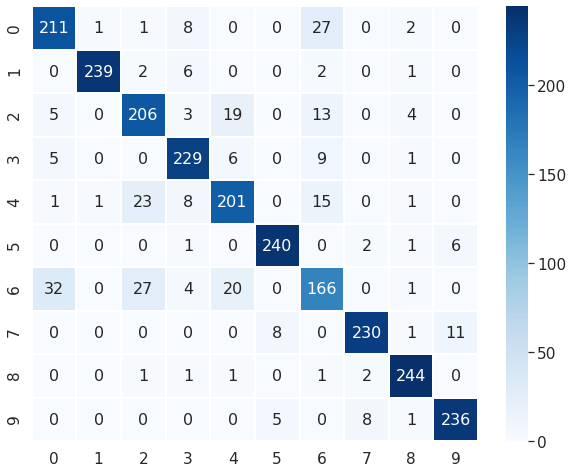

In [560]:
df_cm = pd.DataFrame(confusion.astype(int), index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,8))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,cmap="Blues", annot=True,fmt="d",linewidth=1,annot_kws={"size": 16})

# 2(D)